In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

import keras

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras
print (keras.__version__)

%matplotlib inline
sns.set(style="white")

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8] # width, height

Using TensorFlow backend.


2.1.4


In [2]:
# Configuration 

# Data sources
include_bitcoin = 1
include_ethereum = 1
include_litecoin = 1
include_ripple = 1
include_goog_trends = 1
include_stocktwits = 0

# Data duration (training + test)
start_date_ = '2015-08-07'
end_date_ = '2018-04-18'

start_date = start_date_.replace("-", "")
end_date = end_date_.replace("-", "")

split_date = '2018-01-20'  # >10% of full dataset

# Target : Predict bitcoin (OR ethereum) daily returns OR volatility 
# target = 'btc_daily_ret'
target = 'btc_volatility'

# target = 'eth_daily_ret'
# target = 'eth_volatility'

# Explore further
# target = 'ltc_daily_ret'
# target = 'xrp_daily_ret'

coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}


In [3]:
# Load dataset
dataset_df = pd.read_pickle("data/full_dataset.pkl")

In [4]:
dataset_df.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


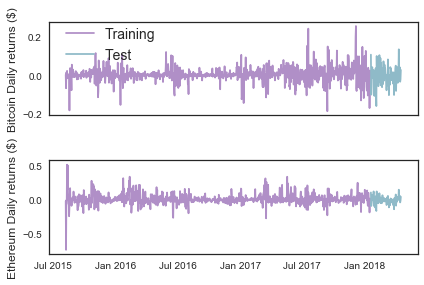

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_daily_ret'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_daily_ret'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_daily_ret'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_daily_ret'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily returns ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily returns ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

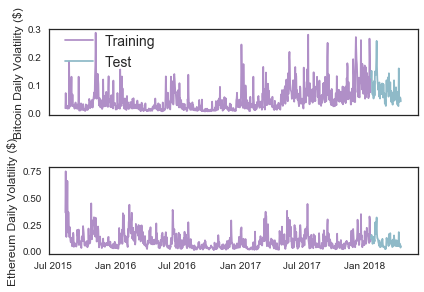

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['btc_volatility'], 
         color='#B08FC7', label='Training')
ax1.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['btc_volatility'], 
         color='#8FBAC8', label='Test')
ax2.plot(dataset_df[dataset_df['Date'] < split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] < split_date]['eth_volatility'], 
         color='#B08FC7')
ax2.plot(dataset_df[dataset_df['Date'] >= split_date]['Date'].astype(datetime.datetime),
         dataset_df[dataset_df['Date'] >= split_date]['eth_volatility'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Daily Volatility ($)',fontsize=12)
ax2.set_ylabel('Ethereum Daily Volatility ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

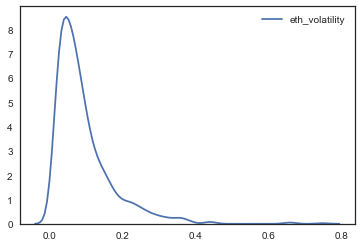

In [7]:
sns.kdeplot(dataset_df['eth_volatility'])

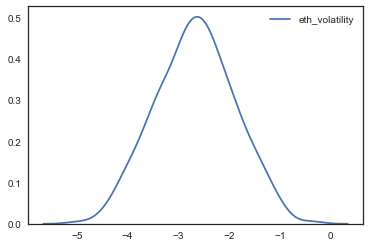

In [8]:
sns.kdeplot(np.log(dataset_df['eth_volatility']))

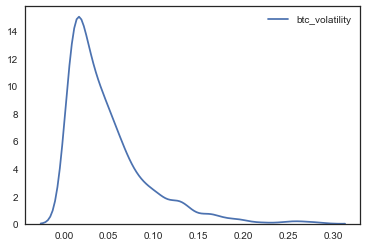

In [9]:
sns.kdeplot(dataset_df['btc_volatility'])

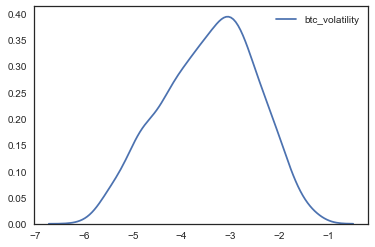

In [10]:
sns.kdeplot(np.log(dataset_df['btc_volatility']))

In [11]:
dataset_df['eth_volatility'] = np.log(dataset_df['eth_volatility'])
dataset_df['btc_volatility'] = np.log(dataset_df['btc_volatility'])

# Benchmarks

Benchmark -I: Price-Persistent model, assumes the close price is same as the previous day. Implies that the estimated daily returns and volatility are both zero

Benchmark - II: Market-Persistent model, assumes the daily returns is same as the previous day. Implies the estimated daily returns and volatility are same as the previous day.

In [12]:
## Price-PERSISTENT MODEL: Benchmark-I

print ("Predicting:", target)

# Evaluate on test dataset
# no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
actual_target = dataset_df[dataset_df['Date']>= split_date][target].values
# pred_target = 0

bm1_mae = np.mean(np.absolute((actual_target)))
bm1_mse = np.mean(np.square((actual_target)))

print("Benchmark-I: MAE", bm1_mae)
print("Benchmark-I: MSE", bm1_mse)

Predicting: btc_volatility
Benchmark-I: MAE 2.634264923378126
Benchmark-I: MSE 7.188424481804465


In [13]:
## Market-PERSISTENT MODEL: Benchmark-II

# Evaluate on test dataset
# same market behavior as previous day
pred_target = dataset_df[dataset_df['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)][target][:-1].values

bm2_mae = np.mean(np.absolute((actual_target-pred_target)))
bm2_mse = np.mean(np.square((actual_target-pred_target)))

print("Benchmark-II: MAE", bm2_mae)
print("Benchmark-II: MSE", bm2_mse)

Benchmark-II: MAE 0.4218536832328074
Benchmark-II: MSE 0.2821991334719368


In [14]:
## LSTM Begins
symbols_ = [symbol+"_" for symbol in list(coin_symbol.values())]

model_data = dataset_df
model_data.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


In [15]:
# LSTM Parameters
window_len = 2 # 2 # 7 # 14 # 30

training_set, test_set = model_data[model_data['Date']<split_date], \
                         model_data[model_data['Date']>=datetime.datetime.strptime(split_date, '%Y-%m-%d')-datetime.timedelta(days=window_len)]

# we don't need the date columns anymore
########### DONT'WE ?? - If we are to cross-validation, we need the dates!! or we just use the index?
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [16]:
no_of_features = training_set.shape[1]

# Columns to be normalized - Instead of traditional normalization aschemes (like MinMax on training_set), 
# normalize the columns w.r.t to the first element of the window s.t the normalized first element would be 0 
# Reference: 
norm_cols = [[symbol+metric for symbol in symbols_ for metric in ['Close','Volume']]          
             +[coin_symbol[coin]+"_trends" for coin in coins]]

norm_cols

[['btc_Close',
  'btc_Volume',
  'eth_Close',
  'eth_Volume',
  'ltc_Close',
  'ltc_Volume',
  'xrp_Close',
  'xrp_Volume',
  'btc_trends',
  'eth_trends',
  'ltc_trends',
  'xrp_trends']]

In [107]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = training_set[target][window_len:].values

In [108]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = test_set[target][window_len:].values

print(len(training_set))
print(len(test_set))

897
91


In [109]:
# ???  easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

type(LSTM_test_inputs)
print(LSTM_test_inputs.shape, LSTM_training_inputs.shape)

(89, 2, 32) (895, 2, 32)


In [20]:
# Function to create model, required for KerasRegressor
def create_model(dropout, neurons, activ_func, optimizer):
    # use default values
    loss= 'mse'
    output_size = 1 # TODO: Can we change this to 2 or even 4 (to predict all 4 at a time - {eth, btc}_{volatility, daily_ret})
    
    print ("Start model: ", dropout, neurons)
    
    model = Sequential()

    # Add 3 layers of LSTM, followed by a dense layer
    model.add(LSTM(neurons[0], return_sequences=True, input_shape=(window_len, no_of_features)))
    model.add(Dropout(dropout))
    # from keras.layers.normalization import BatchNormalization
    # model.add(BatchNormalization())
    
    model.add(LSTM(neurons[1], return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(neurons[2]))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    print ("End compilation of model: ", dropout, neurons)
        
    return model

In [127]:
# Set random seed for reproducibility
np.random.seed(42)

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=2)
# model.fit(predictors, target, validation_split=0.3, epochs=100, callbacks=[early_stopping_monitor])

# create model
model = KerasRegressor(build_fn=create_model, batch_size=4, epochs=15) #, callbacks=[early_stopping_monitor]) 

##############################################################
# grid search: dropout, neurons, optimizer, activation
dropout = [0.4, 0.5, 0.6]  # [0.25, 0.5, 0.75]
neurons = [[10, 8, 4], [20, 16, 8] ] # , [40, 32, 16]] # [80, 64, 32], [160, 128, 64]
activations = ['linear', 'tanh'] # , 'linear'] # , 'sigmoid']
optimizer = ['adam'] # ['sgd', 'rmsprop'] #, 'adam']
param_space = dict(dropout=dropout, neurons=neurons, activ_func=activations, optimizer=optimizer)
##############################################################

tseries_cv = TimeSeriesSplit(n_splits=5).split(LSTM_training_inputs)

grid = GridSearchCV(estimator=model, param_grid=param_space, n_jobs=1, cv=tseries_cv, verbose=5)

print ("Train input shape: ", LSTM_training_inputs.shape)
print ("Train output shape: ", LSTM_training_outputs.shape)

grid_result = grid.fit(LSTM_training_inputs, LSTM_training_outputs)

Train input shape:  (895, 2, 32)
Train output shape:  (895,)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] activ_func=linear, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 12s 82ms/step - loss: 12.7059
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 11.3527
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 9.1183
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 6.1872
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 3.7872
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 2.9398
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 2.5990
Epoch 8/15
150/150 [==============================] - 0s 2ms/step - loss: 2.2773
Epoch 9/15
150/150 [==============================] - 0s 2ms/step - loss: 2.4947
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
299/299 [==============================] - 13s 42ms/step - loss: 14.7370
Epoch 2/15
299/299 [==============================] - 0s 2ms/step - loss: 11.8781
Epoch 3/15
299/299 [==============================] - 0s 2ms/step - loss: 5.7877
Epoch 4/15
299/299 [==============================] - 1s 2ms/step - loss: 3.2313
Epoch 5/15
299/299 [==============================] - 1s 2ms/step - loss: 2.7977A: 0s - loss: 2.
Epoch 6/15
299/299 [==============================] - 0s 1ms/step - loss: 3.0225
Epoch 7/15
299/299 [==============================] - 0s 2ms/step - loss: 2.6006
Epoch 8/15
299/299 [==============================] - 1s 2ms/step - loss: 2.5841
Epoch 9/15
299/299 [==============================] - 1s 2ms/step - loss: 2.4912
Epoch 10/15
299/299 [==============================] - 0s 1ms/step - loss: 2.6472
Epoch 11/15
299/299 [==============================] - 0s 1ms/step - loss: 2.4475
Epoch 12/15
299/299 [========================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
448/448 [==============================] - 13s 29ms/step - loss: 15.3570
Epoch 2/15
448/448 [==============================] - 1s 2ms/step - loss: 9.0750
Epoch 3/15
448/448 [==============================] - 1s 2ms/step - loss: 3.0170
Epoch 4/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7154
Epoch 5/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7841
Epoch 6/15
448/448 [==============================] - 1s 2ms/step - loss: 2.6449
Epoch 7/15
448/448 [==============================] - 1s 2ms/step - loss: 2.8231
Epoch 8/15
448/448 [==============================] - 1s 2ms/step - loss: 2.8853
Epoch 9/15
448/448 [==============================] - 1s 2ms/step - loss: 2.5432
Epoch 10/15
448/448 [==============================] - 1s 2ms/step - loss: 2.7033
Epoch 11/15
448/448 [==============================] - 1s 2ms/step - loss: 2.5736
Epoch 12/15
448/448 [==============================] - 1s 2ms/

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
597/597 [==============================] - 13s 22ms/step - loss: 12.6169
Epoch 2/15
597/597 [==============================] - 2s 3ms/step - loss: 3.8227
Epoch 3/15
597/597 [==============================] - 1s 2ms/step - loss: 2.8595
Epoch 4/15
597/597 [==============================] - 1s 2ms/step - loss: 3.2271
Epoch 5/15
597/597 [==============================] - 1s 2ms/step - loss: 3.0679
Epoch 6/15
597/597 [==============================] - 1s 2ms/step - loss: 2.6415
Epoch 7/15
597/597 [==============================] - 1s 2ms/step - loss: 2.3918
Epoch 8/15
597/597 [==============================] - 1s 2ms/step - loss: 2.5730
Epoch 9/15
597/597 [==============================] - 1s 2ms/step - loss: 2.3042
Epoch 10/15
597/597 [==============================] - 1s 2ms/step - loss: 2.3931
Epoch 11/15
597/597 [==============================] - 1s 2ms/step - loss: 2.2372
Epoch 12/15
597/597 [==============================] - 1s 2ms/

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
746/746 [==============================] - 11s 15ms/step - loss: 10.7852
Epoch 2/15
746/746 [==============================] - 1s 2ms/step - loss: 3.2120
Epoch 3/15
746/746 [==============================] - 1s 2ms/step - loss: 2.8551
Epoch 4/15
746/746 [==============================] - 1s 1ms/step - loss: 2.4572
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 2.6437
Epoch 6/15
746/746 [==============================] - 1s 2ms/step - loss: 2.4015
Epoch 7/15
746/746 [==============================] - 1s 1ms/step - loss: 2.3859
Epoch 8/15
746/746 [==============================] - 1s 1ms/step - loss: 2.2682
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 2.2532
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9702
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 2.1019
Epoch 12/15
746/746 [==============================] - 1s 2ms/

746/746 [==============================] - 1s 2ms/step - loss: 2.1078
Epoch 3/15
746/746 [==============================] - 1s 2ms/step - loss: 1.8864
Epoch 4/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9253
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 1.5890
Epoch 6/15
746/746 [==============================] - 1s 2ms/step - loss: 1.5605
Epoch 7/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6535
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3485
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3870
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3135
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 1.4506
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3015
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.1683
Epoch 14/15
746/746 [==============

746/746 [==============================] - 1s 2ms/step - loss: 3.2611
Epoch 5/15
746/746 [==============================] - 1s 2ms/step - loss: 3.0797
Epoch 6/15
746/746 [==============================] - 1s 2ms/step - loss: 2.8319
Epoch 7/15
746/746 [==============================] - 1s 2ms/step - loss: 2.7990
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 2.8530
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 2.6422
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 2.2282
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 2.3972
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 2.1791
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.7692
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9738
Epoch 15/15
746/746 [==============================] - 1s 698us/step
[CV]  activ_func=linear, dropout=0.5, neurons=

746/746 [==============================] - 1s 2ms/step - loss: 2.0366
Epoch 7/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9584
Epoch 8/15
746/746 [==============================] - 1s 2ms/step - loss: 1.9091
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 1.8706
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 1.6105
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 1.7426
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 1.7007
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 1.5891
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 1.3205
Epoch 15/15
746/746 [==============================] - 1s 797us/step
[CV]  activ_func=linear, dropout=0.5, neurons=[20, 16, 8], optimizer=adam, score=-0.3647756528534345, total=  46.7s
[CV] activ_func=linear, dropout=0.6, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.6 [

746/746 [==============================] - 1s 2ms/step - loss: 3.2653
Epoch 9/15
746/746 [==============================] - 1s 2ms/step - loss: 3.2757
Epoch 10/15
746/746 [==============================] - 1s 2ms/step - loss: 2.9113
Epoch 11/15
746/746 [==============================] - 1s 2ms/step - loss: 2.7210
Epoch 12/15
746/746 [==============================] - 1s 2ms/step - loss: 2.7654
Epoch 13/15
746/746 [==============================] - 1s 2ms/step - loss: 2.7058
Epoch 14/15
746/746 [==============================] - 1s 2ms/step - loss: 2.3540
Epoch 15/15
746/746 [==============================] - 1s 742us/step
[CV]  activ_func=linear, dropout=0.6, neurons=[10, 8, 4], optimizer=adam, score=-0.43364692734391896, total=  50.6s
[CV] activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.6 [20, 16, 8]
End compilation of model:  0.6 [20, 16, 8]
Epoch 1/15
150/150 [==============================] - 16s 109ms/step - loss: 12.5026
Epoch 2/15
150/150 [==

746/746 [==============================] - 2s 2ms/step - loss: 1.8801
Epoch 11/15
746/746 [==============================] - 2s 3ms/step - loss: 1.8527
Epoch 12/15
746/746 [==============================] - 2s 3ms/step - loss: 1.8335
Epoch 13/15
746/746 [==============================] - 2s 3ms/step - loss: 1.8341
Epoch 14/15
746/746 [==============================] - 2s 2ms/step - loss: 1.5248
Epoch 15/15
746/746 [==============================] - 1s 1ms/step
[CV]  activ_func=linear, dropout=0.6, neurons=[20, 16, 8], optimizer=adam, score=-0.2933381913892375, total=  58.8s
[CV] activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.4 [10, 8, 4]
End compilation of model:  0.4 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 18s 121ms/step - loss: 12.7974
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 11.2907
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 9.8255
Epoch 4/15
150/150 [=========

746/746 [==============================] - 2s 2ms/step - loss: 8.2284
Epoch 13/15
746/746 [==============================] - 2s 2ms/step - loss: 8.2250
Epoch 14/15
746/746 [==============================] - 2s 2ms/step - loss: 8.2165
Epoch 15/15
746/746 [==============================] - 1s 902us/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[10, 8, 4], optimizer=adam, score=-3.1159111645397726, total= 1.1min
[CV] activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.4 [20, 16, 8]
End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
150/150 [==============================] - 22s 144ms/step - loss: 12.5458
Epoch 2/15
150/150 [==============================] - 0s 3ms/step - loss: 10.2626
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 7.9834
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 7.3709
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 7.2890
Epoch 6/15
150/150 [=========

746/746 [==============================] - 2s 3ms/step - loss: 8.1132
Epoch 15/15
746/746 [==============================] - 1s 1ms/step
[CV]  activ_func=tanh, dropout=0.4, neurons=[20, 16, 8], optimizer=adam, score=-3.1153134803643963, total= 1.3min
[CV] activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam 
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 25s 166ms/step - loss: 12.9349
Epoch 2/15
150/150 [==============================] - 0s 3ms/step - loss: 12.0426
Epoch 3/15
150/150 [==============================] - 0s 3ms/step - loss: 11.0583
Epoch 4/15
150/150 [==============================] - 0s 3ms/step - loss: 9.7987
Epoch 5/15
150/150 [==============================] - 0s 3ms/step - loss: 8.8810
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 8.3606
Epoch 7/15
150/150 [==============================] - 0s 3ms/step - loss: 8.1198
Epoch 8/15
150/150 [==============

746/746 [==============================] - 1s 1ms/step
[CV]  activ_func=tanh, dropout=0.5, neurons=[10, 8, 4], optimizer=adam, score=-3.1154838728424687, total= 1.3min
[CV] activ_func=tanh, dropout=0.5, neurons=[20, 16, 8], optimizer=adam 
Start model:  0.5 [20, 16, 8]
End compilation of model:  0.5 [20, 16, 8]
Epoch 1/15
150/150 [==============================] - 29s 194ms/step - loss: 12.7047
Epoch 2/15
150/150 [==============================] - 0s 3ms/step - loss: 10.6172
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 8.5001
Epoch 4/15
150/150 [==============================] - 0s 3ms/step - loss: 7.8016
Epoch 5/15
150/150 [==============================] - 0s 3ms/step - loss: 7.4830
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 7.3321
Epoch 7/15
150/150 [==============================] - 0s 3ms/step - loss: 7.2819
Epoch 8/15
150/150 [==============================] - 0s 3ms/step - loss: 7.3137
Epoch 9/15
150/150 [==============

End compilation of model:  0.6 [10, 8, 4]
Epoch 1/15
150/150 [==============================] - 31s 206ms/step - loss: 13.0195
Epoch 2/15
150/150 [==============================] - 0s 3ms/step - loss: 12.4127
Epoch 3/15
150/150 [==============================] - 0s 3ms/step - loss: 11.5924
Epoch 4/15
150/150 [==============================] - 0s 3ms/step - loss: 10.9049
Epoch 5/15
150/150 [==============================] - 0s 3ms/step - loss: 10.0915
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 9.6482
Epoch 7/15
150/150 [==============================] - 0s 3ms/step - loss: 8.9151
Epoch 8/15
150/150 [==============================] - 0s 3ms/step - loss: 8.4287
Epoch 9/15
150/150 [==============================] - 0s 3ms/step - loss: 8.1158
Epoch 10/15
150/150 [==============================] - 0s 3ms/step - loss: 8.2335
Epoch 11/15
150/150 [==============================] - 0s 3ms/step - loss: 8.3868
Epoch 12/15
150/150 [==============================] - 0s

150/150 [==============================] - 0s 3ms/step - loss: 9.5396
Epoch 4/15
150/150 [==============================] - 0s 3ms/step - loss: 8.4474
Epoch 5/15
150/150 [==============================] - 0s 3ms/step - loss: 7.8187
Epoch 6/15
150/150 [==============================] - 0s 3ms/step - loss: 7.6946
Epoch 7/15
150/150 [==============================] - 1s 4ms/step - loss: 7.5216
Epoch 8/15
150/150 [==============================] - 0s 3ms/step - loss: 7.5688
Epoch 9/15
150/150 [==============================] - 0s 3ms/step - loss: 7.3855
Epoch 10/15
150/150 [==============================] - 0s 3ms/step - loss: 7.3553
Epoch 11/15
150/150 [==============================] - 0s 3ms/step - loss: 7.4768
Epoch 12/15
150/150 [==============================] - 0s 3ms/step - loss: 7.2870
Epoch 13/15
150/150 [==============================] - 1s 4ms/step - loss: 7.3039
Epoch 14/15
150/150 [==============================] - 1s 4ms/step - loss: 7.2148
Epoch 15/15
150/150 [=============

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 55.5min finished


End compilation of model:  0.4 [20, 16, 8]
Epoch 1/15
895/895 [==============================] - 46s 51ms/step - loss: 5.1406
Epoch 2/15
895/895 [==============================] - 3s 3ms/step - loss: 1.8432
Epoch 3/15
895/895 [==============================] - 3s 3ms/step - loss: 1.6789
Epoch 4/15
895/895 [==============================] - 3s 3ms/step - loss: 1.5036
Epoch 5/15
895/895 [==============================] - 3s 3ms/step - loss: 1.4632
Epoch 6/15
895/895 [==============================] - 3s 3ms/step - loss: 1.3153
Epoch 7/15
895/895 [==============================] - 3s 3ms/step - loss: 1.3201
Epoch 8/15
895/895 [==============================] - 3s 3ms/step - loss: 1.2851
Epoch 9/15
895/895 [==============================] - 3s 3ms/step - loss: 1.2537
Epoch 10/15
895/895 [==============================] - 3s 3ms/step - loss: 1.1674
Epoch 11/15
895/895 [==============================] - 3s 3ms/step - loss: 1.1359
Epoch 12/15
895/895 [==============================] - 3s 3ms/

In [22]:
# fig, ax1 = plt.subplots(1,1)

# ax1.plot(bt_history.epoch, bt_history.history['loss'])
# ax1.set_title('Training Error')

# if bt_model.loss == 'mae':
#     ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# elif bt_model.loss == 'mse':
#     ax1.set_ylabel('Mean Squared Error (MSE)',fontsize=12)
# else:
#     ax1.set_ylabel('Model Loss',fontsize=12)
# ax1.set_xlabel('# Epochs',fontsize=12)
# plt.show()

In [150]:
# print(grid_result.cv_results_)
df = pd.DataFrame(grid_result.cv_results_)
# df['params'] = df['params'].values # Use apply() or lambda()
# pd.set_option('max_colwidth',200)

df['active_func'] = [ x['activ_func'] for x in df['params'].values]
df['dropout'] = [ x['dropout'] for x in df['params'].values]
df['neurons'] = [ x['neurons'] for x in df['params'].values]
df['optimizer'] = [ x['optimizer'] for x in df['params'].values]
df.drop(columns='params', inplace=True)

df[['active_func', 'dropout', 'neurons', 'optimizer', 'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score']]

C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\praveeno\AppData\Local\Continuum\Anaconda2\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, 

,active_func,dropout,neurons,optimizer,mean_train_score,mean_test_score,std_train_score,std_test_score
0,linear,0.4,"[10, 8, 4]",adam,-0.705460,-0.779714,0.073267,0.422923
1,linear,0.4,"[20, 16, 8]",adam,-0.546961,-0.612087,0.023364,0.249723
2,linear,0.5,"[10, 8, 4]",adam,-0.799889,-0.884254,0.100876,0.540445
3,linear,0.5,"[20, 16, 8]",adam,-0.597764,-0.689718,0.057597,0.308302
4,linear,0.6,"[10, 8, 4]",adam,-0.978641,-0.974296,0.120932,0.530123
5,linear,0.6,"[20, 16, 8]",adam,-0.690736,-0.704029,0.091735,0.323031
6,tanh,0.4,"[10, 8, 4]",adam,-8.463913,-7.298801,0.775797,3.063501
7,tanh,0.4,"[20, 16, 8]",adam,-8.460370,-7.295089,0.776167,3.060236
8,tanh,0.5,"[10, 8, 4]",adam,-8.462258,-7.297177,0.774331,3.062151
9,tanh,0.5,"[20, 16, 8]",adam,-8.460452,-7.295198,0.775957,3.060380


In [46]:
bt_model = grid_result.best_estimator_
print(grid_result.best_params_.values())
print(grid_result.best_score_)

dict_values(['linear', 0.4, [20, 16, 8], 'adam'])
-0.6143127745829973


# Sensitivity Analysis

Add random noise (with normal distribution) to training and test inputs, and study the mean & variance of the final model's predictions

In [50]:
training_set_

,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,btc_volatility,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,-4.238998,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,29.0,62.0,69.0,78.0
1,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,-2.677909,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,33.0,35.0,42.0,64.0
2,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,-3.688573,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,42.0,45.0,70.0
3,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,-4.093140,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,32.0,38.0,45.0,67.0
4,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,-3.736687,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,29.0,40.0,48.0,59.0


In [82]:
training_set.std()

btc_Close             3.582844e+03
btc_Volume            3.477363e+09
eth_Close             2.174368e+02
eth_Volume            1.095198e+09
ltc_Close             5.641339e+01
ltc_Volume            4.645573e+08
xrp_Close             3.805760e-01
xrp_Volume            8.936849e+08
btc_close_off_high    5.879705e-01
btc_volatility        9.510710e-01
btc_daily_ret         3.948718e-02
btc_7day_ret          1.525010e-02
btc_30day_ret         1.081708e-02
eth_close_off_high    5.824458e-01
eth_volatility        7.984997e-01
eth_daily_ret         7.932702e-02
eth_7day_ret          4.320621e-02
eth_30day_ret         4.060681e-02
ltc_close_off_high    6.007232e-01
ltc_volatility        7.057461e-02
ltc_daily_ret         6.260167e-02
ltc_7day_ret          2.611531e-02
ltc_30day_ret         1.613154e-02
xrp_close_off_high    6.612787e-01
xrp_volatility        1.208893e-01
xrp_daily_ret         9.923092e-02
xrp_7day_ret          4.421914e-02
xrp_30day_ret         2.641212e-02
btc_trends          

In [121]:
num_iter = 10
lstm_test_mse = []
lstm_train_mse = []

for i in range(num_iter):
    training_set_rand = training_set + 2*(-0.5+np.random.rand(*training_set.shape))*training_set.std().values/1000 # + 2*(-0.5+np.random.rand(*training_set.shape))*training_set.std().values/10
    test_set_rand = test_set + 2*(-0.5+np.random.rand(*test_set.shape))*test_set.std().values/1000

    LSTM_training_inputs_rand = []
    for i in range(len(training_set_rand)-window_len):
        temp_set = training_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_training_inputs_rand.append(temp_set)
        
    LSTM_test_inputs_rand = []
    for i in range(len(test_set_rand)-window_len):
        temp_set = test_set_rand[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        LSTM_test_inputs_rand.append(temp_set)

    # Convert to numpy arrays
    LSTM_training_inputs_rand = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs_rand]
    LSTM_training_inputs_rand = np.array(LSTM_training_inputs_rand)

    LSTM_test_inputs_rand = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs_rand]
    LSTM_test_inputs_rand = np.array(LSTM_test_inputs_rand)

    lstm_test_mse.append(np.mean(np.square(bt_model.predict(LSTM_test_inputs_rand)-(test_set[target].values[window_len:]))))
    lstm_train_mse.append(np.mean(np.square(bt_model.predict(LSTM_training_inputs_rand)-(training_set[target].values[window_len:]))))

print (lstm_test_mse)
print (lstm_train_mse)

print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

# print(LSTM_training_inputs)

[0.2089328223105582, 0.208967615866258, 0.2090458829887039, 0.20899986675872168, 0.20900751536490886, 0.20892404135447581, 0.2090662004742719, 0.20896592936765046, 0.20896238111883958, 0.20896937546779726]
[0.5617783887758425, 0.5577880408330487, 0.5658707230288796, 0.5554261387442742, 0.56986831197898, 0.5595996415248827, 0.558108269339404, 0.554772454454147, 0.5559850720938317, 0.5632433008542846]
0.20898416310721854 4.345263889270337e-05
0.5602440341627575 0.004668339008782886


In [122]:
print (np.mean(lstm_test_mse), np.std(lstm_test_mse))
print (np.mean(lstm_train_mse), np.std(lstm_train_mse))

x

0.20898416310721854 4.345263889270337e-05
0.5602440341627575 0.004668339008782886


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [123]:
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_training_inputs)-(training_set[target].values[window_len:])))
print(lstm_mse)

0.5507555560070195


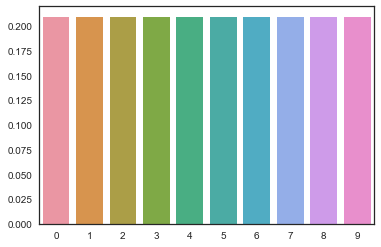

In [124]:
x_ = [a for a in range(10)]
sns.barplot(x=x_, y=lstm_test_mse)

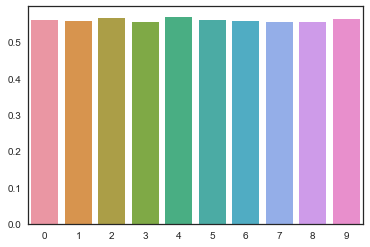

In [125]:
sns.barplot(x=x_, y=lstm_train_mse)

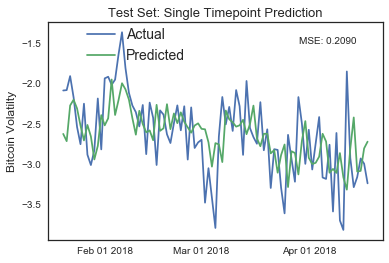

In [126]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_test_inputs)-(test_set[target].values[window_len:])))
ax1.annotate('MSE: %.4f'%lstm_mse, xy=(0.75, 0.9),  xycoords='axes fraction', xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatilty',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 895 arrays: [array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.98538176e-01,
        -4.24921003e+0...

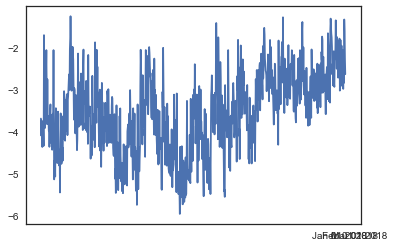

In [106]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MSE: %.4f'%np.mean(np.square(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Volatility',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [27]:
pred_values = bt_model.predict(LSTM_training_inputs)
max(pred_values)
min(pred_values)

-4.3423424

In [28]:
print (bm1_mse)
print (bm2_mse)
print (lstm_mse)

7.188424481804465
0.2821991334719368
0.20900524188045577


In [29]:
temp = create_model(0.5, [10, 8, 4], 'linear', 'adam')

temp.summary()

Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 2, 10)             1720      
_________________________________________________________________
dropout_64 (Dropout)         (None, 2, 10)             0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 2, 8)              608       
_________________________________________________________________
dropout_65 (Dropout)         (None, 2, 8)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dropout_66 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense

Log (Bitcoin Volatility) :

{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [20, 16, 8]}
7.188424481804465
0.2821991334719368
0.2323832191539962

Log (Ethereum Volatility):

7.075934943743348
0.26612587735504156
0.250099288542878

Bitcoin Daily returns:

0.0030647863135465233
0.006363817757120959
0.003059795171523061
{'activ_func': 'linear', 'dropout': 0.4, 'neurons': [10, 8, 4]}

Ethereum Daily returns:

{'activ_func': 'linear', 'dropout': 0.5, 'neurons': [10, 8, 4]}
0.003542452975106516
0.007433466612293294
0.003664957524689988

In [69]:
df = pd.DataFrame(1.0, index=[1,2,3,4,5], columns=list('ABC') )
df['B']=20*df['B']
df['C']=500*df['C']

In [70]:
df

,A,B,C
1,1.0,20.0,500.0
2,1.0,20.0,500.0
3,1.0,20.0,500.0
4,1.0,20.0,500.0
5,1.0,20.0,500.0


In [72]:
temp = np.random.rand(*df.shape)
print(temp)
print(temp*(df.mean().values))

[[0.52330328 0.79760024 0.78787196]
 [0.38308215 0.17586173 0.14739764]
 [0.27050707 0.9288314  0.21307953]
 [0.6260833  0.25996514 0.83379057]
 [0.69196035 0.85113876 0.45651204]]
[[5.23303276e-01 1.59520048e+01 3.93935979e+02]
 [3.83082151e-01 3.51723456e+00 7.36988183e+01]
 [2.70507072e-01 1.85766281e+01 1.06539766e+02]
 [6.26083299e-01 5.19930288e+00 4.16895285e+02]
 [6.91960351e-01 1.70227751e+01 2.28256020e+02]]


In [65]:
df.mean().values

array([1., 2., 5.])

In [56]:
df

,A,B,C
1,1.0,2.0,1.0
2,1.0,2.0,1.0
3,1.0,2.0,1.0
4,1.0,2.0,1.0
5,1.0,2.0,1.0
